In [1]:
from tqdm import tqdm
from etnn.nn.baseline import create_baseline_model, calc_params
import pandas as pd
import os
from sklearn.metrics import r2_score
from etnn.tools.training import train_epoch, eval_epoch
from etnn import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from etnn.routines.run_config import choice_trainloader, choice_loss, choice_optim
import torch
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset_single_node
from etnn.tools.training_tools import ConfigStore, seeding_all
import matplotlib.pyplot as plt

In [2]:
dataset_path = "../../datasets/"
test_perc = 0.3
stability_count = 5
label = "tree-advanced" # although irrelevant

In [3]:
def create_plot(
        df,
        what: str = "r2"
) -> None:
    plt.figure()

    # Plot the initial data
    for config_id in df.config_id.unique():
        # make subdataset for config id
        sub_df = df[df.config_id == config_id]
        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            if f"{mode}_{what}" in sub_df.columns:
                plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == "r2":
        plt.ylim(-1, +1)
    elif what == "loss":
        plt.yscale('log')
    plt.legend()
    plt.show()

In [4]:
def run(i, entry, size_elem, normalized, node_type):
    # init default config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=int(entry.params_hidden_dim),
        out_dim=1,
        k=int(entry.params_k),
        dataset=-1 if normalized else 0,
        ds_size=10_000,
        num_gondolas=-1,
        num_part_pg=-1,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=50, # 300, # real: 100
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=5/1000
    )

    # loading dataset
    dataset, df_index = load_pure_ferris_wheel_dataset_single_node(
        node_type=node_type,
        num_elem=size_elem,
        num_to_generate=config.ds_size,
        dataset_path=dataset_path,
        final_label_factor=config.final_label_factor,
        normalize=True if config.dataset == -1 else 0
    )
    # splitting off test dataset
    generator = torch.Generator().manual_seed(config.seed)
    train_ds, test_ds= random_split(
        dataset,
        [1 - test_perc, test_perc],
        generator=generator
    )

    # loaders
    train_loader = choice_trainloader(config, df_index, train_ds)
    test_loader = DataLoader(test_ds, batch_size=4 * config.batch_size, shuffle=False)

    # define device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # set seed for reproducability
    seeding_all(config.seed)

    # define model
    model = LayerManagementFramework(
        in_dim=config.in_dim,
        tree=TreeNode(node_type, [TreeNode("E", size_elem)]),
        hidden_dim=config.hidden_dim,
        out_dim=config.out_dim,
        k=config.k
    ).to(device)
    print(f"Model params etnn: {calc_params(model)}")

    # learning tools
    criterion = choice_loss(config)
    optimizer = choice_optim(config, model)

    # init score list
    train_r2_list = []
    test_r2_list = []
    train_loss_list = []
    test_loss_list = []

    file_name = f"csvs/single-node_node-type-{node_type}_rank-{i}_normalized-{normalized}_n-{size_elem}{'_only-normalized-data' if normalized else ''}.csv"
    if os.path.isfile(file_name):
        df = pd.read_csv(file_name)
    else:
        # train for specified number of epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        # REPEAT FOR BASELINE MODEL
        seeding_all(config.seed)
        # %%
        model, _ = create_baseline_model(
            n_params=calc_params(model),
            input_dim=config.in_dim * size_elem,
            n_layer=3,
            output_dim=1
        )
        model = model.to(device)
        # print(model)

        optimizer = choice_optim(config, model)

        # train for N epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        df = pd.DataFrame({
            "config_id": ["etnn"]*config.num_max_epochs + ["baseline"]*config.num_max_epochs,
            "epoch": list(range(1, config.num_max_epochs + 1))*2,
            "train_loss": train_loss_list,
            "test_loss": test_loss_list,
            "train_r2": train_r2_list,
            "test_r2": test_r2_list
        })
        df.to_csv(file_name)

    # plotting
    create_plot(df, "r2")
    create_plot(df, "loss")

# S

Rank 1 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.923374
datetime_start          2023-12-20 18:43:45.922297
datetime_complete       2023-12-20 18:44:47.816125
duration                    0 days 00:01:01.893828
params_batcher                                True
params_hidden_dim                               80
params_k                                         2
params_learning_rate                      0.006057
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 24801


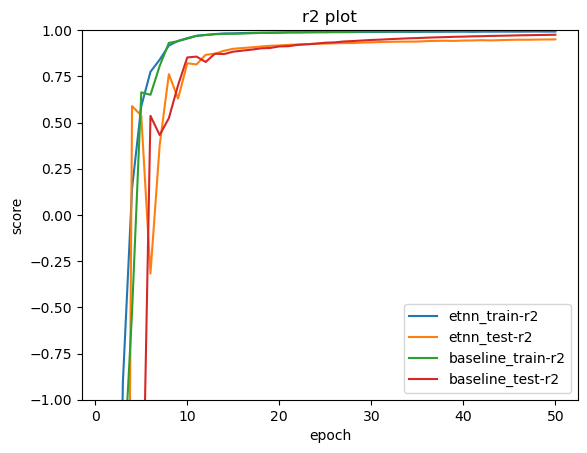

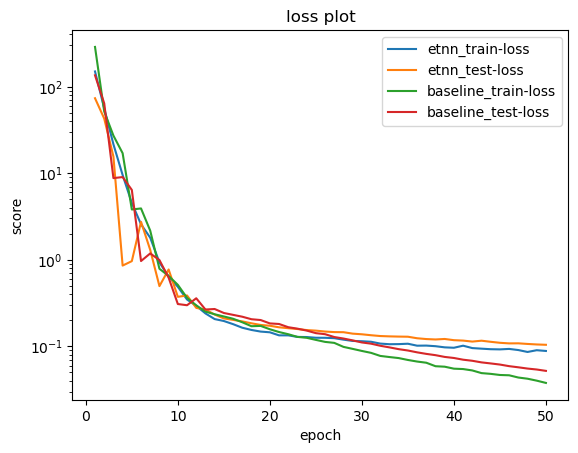

Rank 2 parameter configuration: Unnamed: 0                                      12
number                                          12
value                                     0.922305
datetime_start          2023-12-20 18:44:47.817629
datetime_complete       2023-12-20 18:45:49.400762
duration                    0 days 00:01:01.583133
params_batcher                                True
params_hidden_dim                               80
params_k                                         2
params_learning_rate                      0.008755
state                                     COMPLETE
Name: 12, dtype: object
Model params etnn: 24801


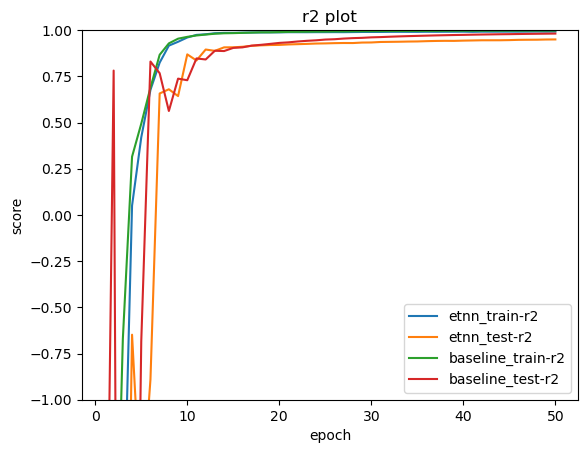

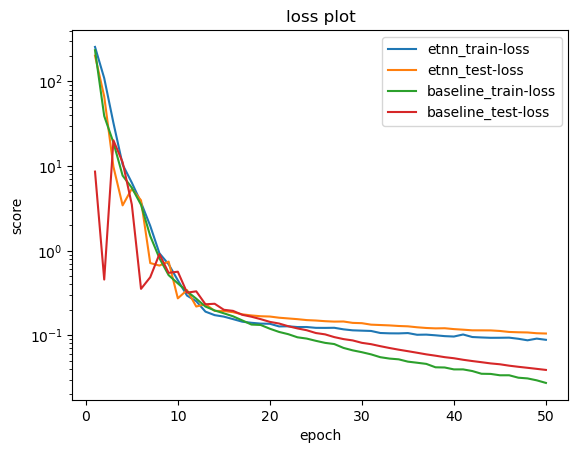

Rank 3 parameter configuration: Unnamed: 0                                      10
number                                          10
value                                     0.921148
datetime_start          2023-12-20 18:42:45.727057
datetime_complete       2023-12-20 18:43:45.921297
duration                    0 days 00:01:00.194240
params_batcher                                True
params_hidden_dim                               80
params_k                                         2
params_learning_rate                      0.008263
state                                     COMPLETE
Name: 10, dtype: object
Model params etnn: 24801


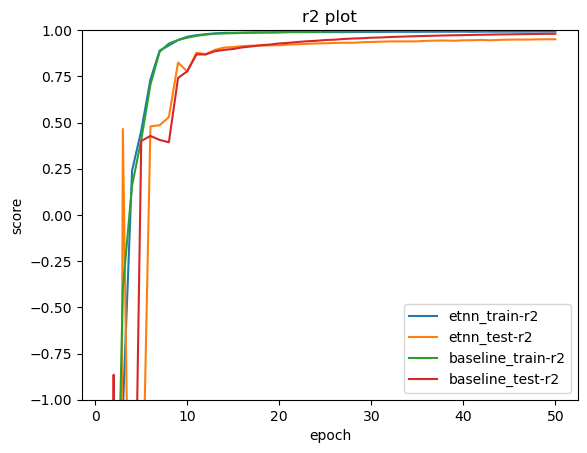

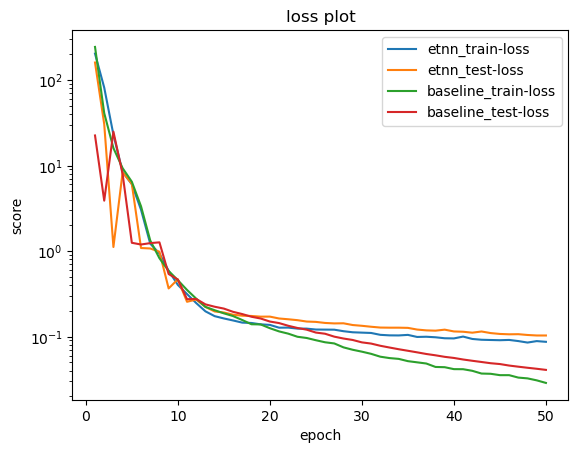

In [5]:
normalized = True
size_elem = 10
node_type = "S"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_normalized-lesser-search.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# Q

Rank 1 parameter configuration: Unnamed: 0                                      10
number                                          10
value                                     0.951075
datetime_start          2023-12-20 19:22:33.772760
datetime_complete       2023-12-20 19:23:36.697575
duration                    0 days 00:01:02.924815
params_batcher                                True
params_hidden_dim                              160
params_k                                         2
params_learning_rate                      0.009948
state                                     COMPLETE
Name: 10, dtype: object
Model params etnn: 96001


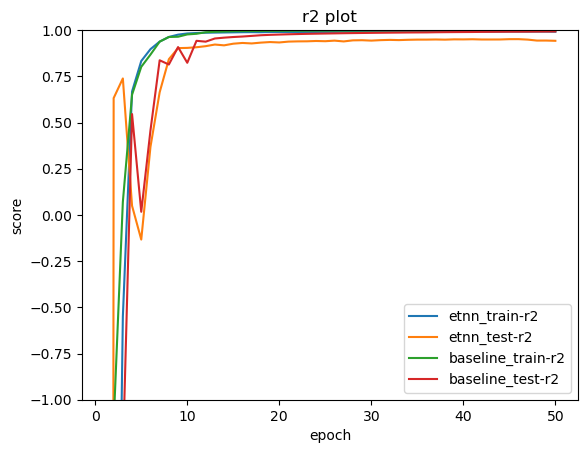

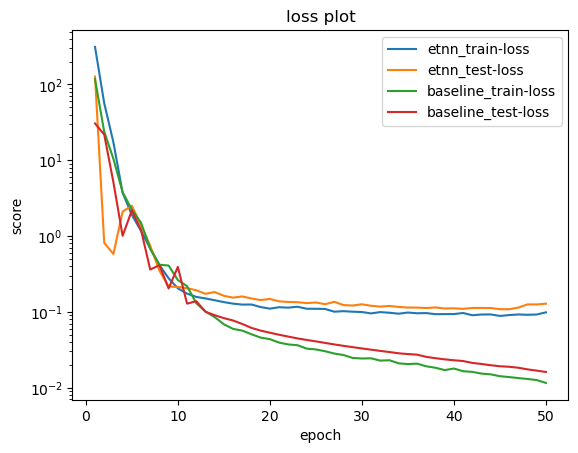

Rank 2 parameter configuration: Unnamed: 0                                       6
number                                           6
value                                     0.949848
datetime_start          2023-12-20 19:18:17.718294
datetime_complete       2023-12-20 19:19:22.667481
duration                    0 days 00:01:04.949187
params_batcher                                True
params_hidden_dim                              160
params_k                                         2
params_learning_rate                      0.007617
state                                     COMPLETE
Name: 6, dtype: object
Model params etnn: 96001


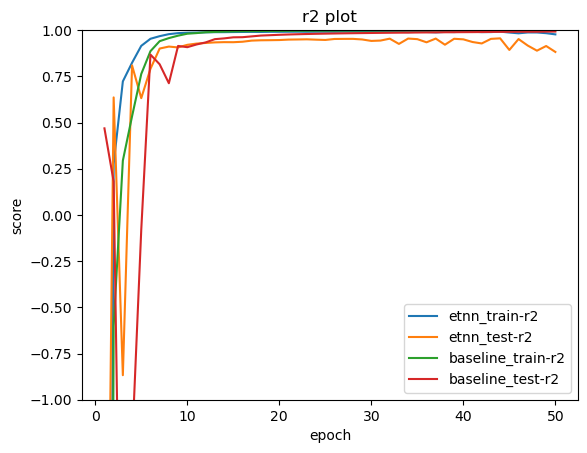

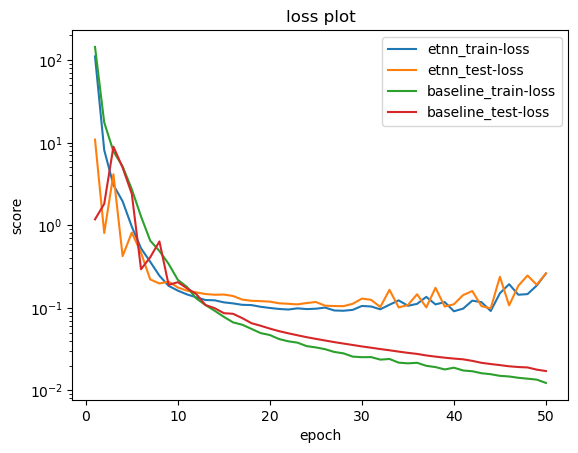

Rank 3 parameter configuration: Unnamed: 0                                       7
number                                           7
value                                     0.945953
datetime_start          2023-12-20 19:19:22.668482
datetime_complete       2023-12-20 19:20:29.536854
duration                    0 days 00:01:06.868372
params_batcher                                True
params_hidden_dim                              224
params_k                                         3
params_learning_rate                      0.001165
state                                     COMPLETE
Name: 7, dtype: object
Model params etnn: 236769


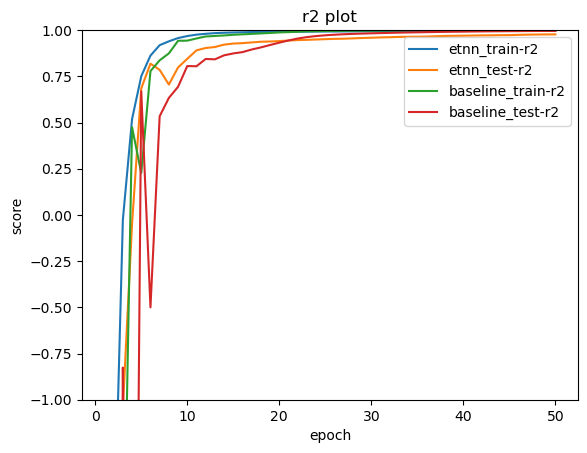

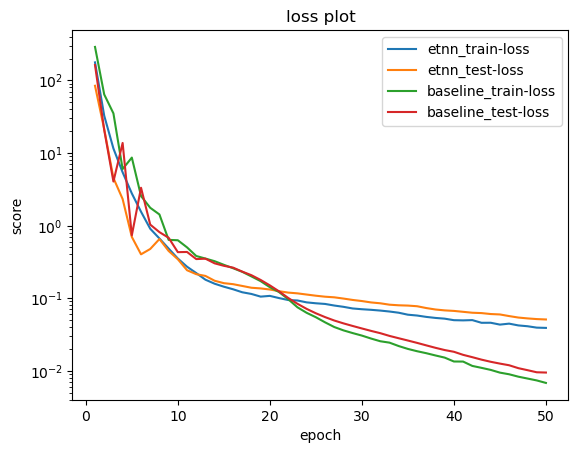

In [6]:
normalized = True
size_elem = 10
node_type = "Q"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_normalized-lesser-search.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# C

Rank 1 parameter configuration: Unnamed: 0                                      10
number                                          10
value                                     0.989765
datetime_start          2023-12-20 19:39:53.401796
datetime_complete       2023-12-20 19:40:57.424605
duration                    0 days 00:01:04.022809
params_batcher                               False
params_hidden_dim                              256
params_k                                         1
params_learning_rate                      0.005966
state                                     COMPLETE
Name: 10, dtype: object
Model params etnn: 176897


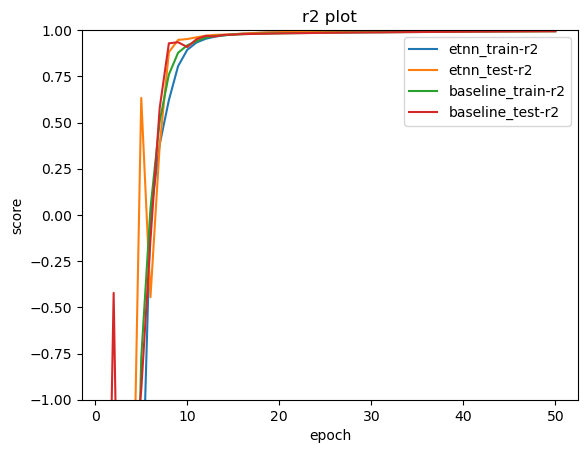

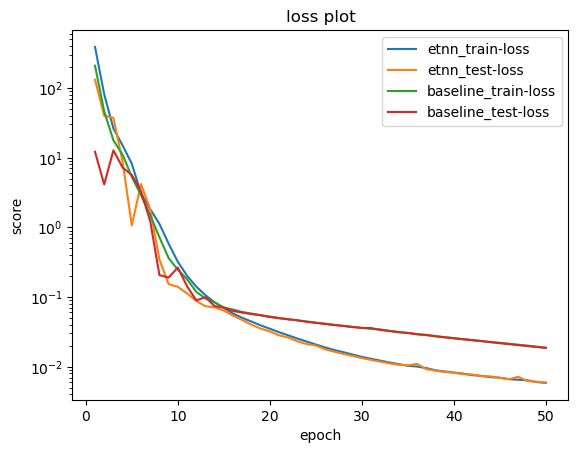

Rank 2 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.987588
datetime_start          2023-12-20 19:40:57.425605
datetime_complete       2023-12-20 19:42:00.995660
duration                    0 days 00:01:03.570055
params_batcher                               False
params_hidden_dim                              240
params_k                                         1
params_learning_rate                       0.00754
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 155761


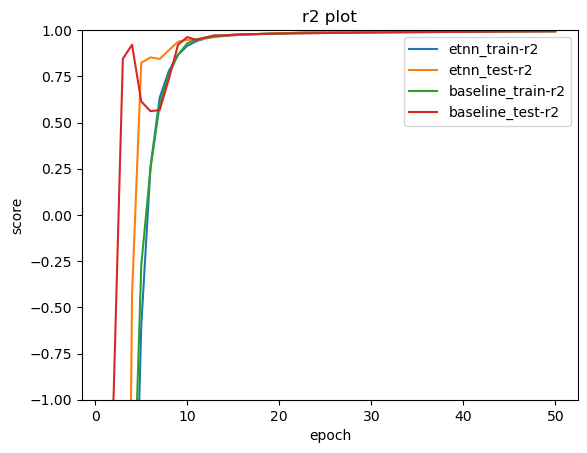

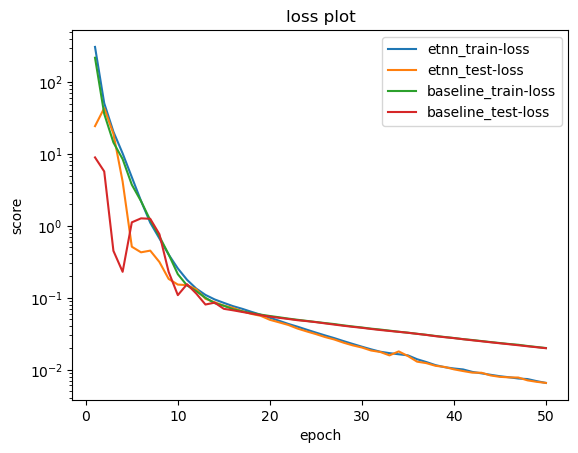

Rank 3 parameter configuration: Unnamed: 0                                       3
number                                           3
value                                     0.976508
datetime_start          2023-12-20 19:31:55.706252
datetime_complete       2023-12-20 19:33:12.259713
duration                    0 days 00:01:16.553461
params_batcher                                True
params_hidden_dim                              208
params_k                                         1
params_learning_rate                      0.004582
state                                     COMPLETE
Name: 3, dtype: object
Model params etnn: 117521


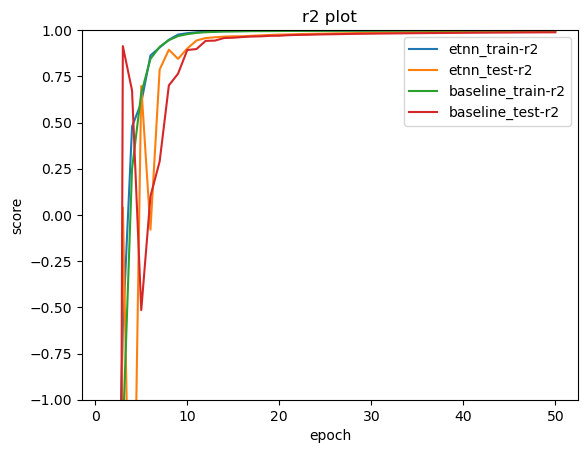

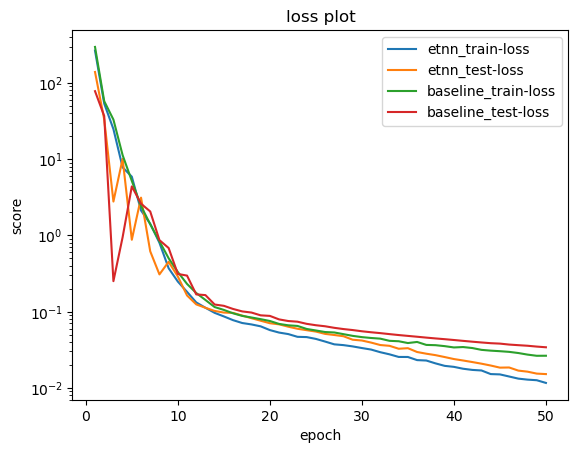

In [7]:
normalized = True
size_elem = 10
node_type = "C"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_normalized-lesser-search.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# P

Rank 1 parameter configuration: Unnamed: 0                                       3
number                                           3
value                                     0.971833
datetime_start          2023-12-20 19:48:14.196477
datetime_complete       2023-12-20 19:49:21.832092
duration                    0 days 00:01:07.635615
params_batcher                                True
params_hidden_dim                              112
params_k                                         1
params_learning_rate                      0.007899
state                                     COMPLETE
Name: 3, dtype: object
Model params etnn: 35057


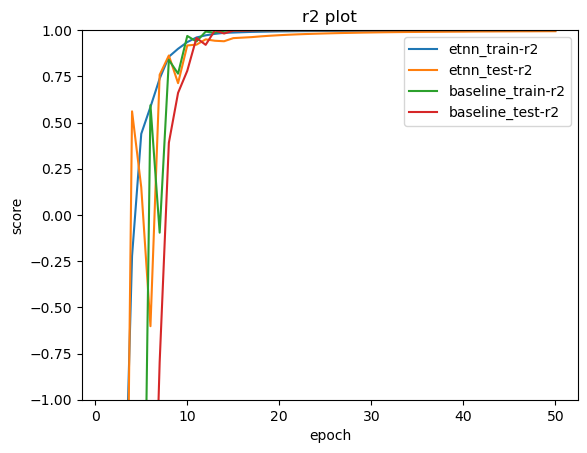

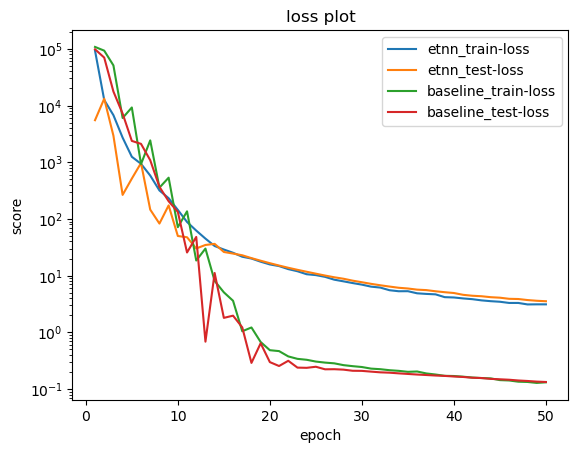

Rank 2 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                     0.928887
datetime_start          2023-12-20 19:58:10.789943
datetime_complete       2023-12-20 19:59:12.893787
duration                    0 days 00:01:02.103844
params_batcher                               False
params_hidden_dim                              144
params_k                                         3
params_learning_rate                      0.007541
state                                     COMPLETE
Name: 11, dtype: object
Model params etnn: 57169


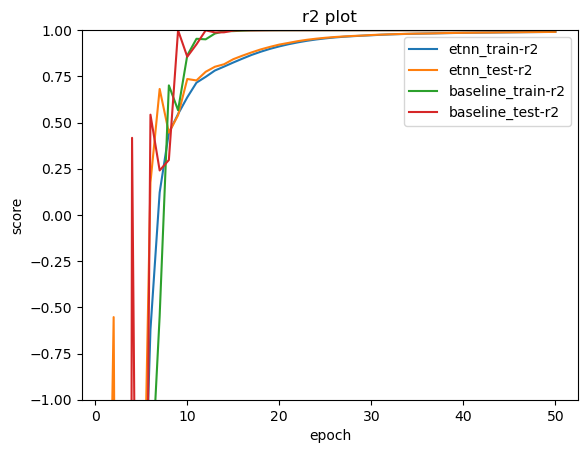

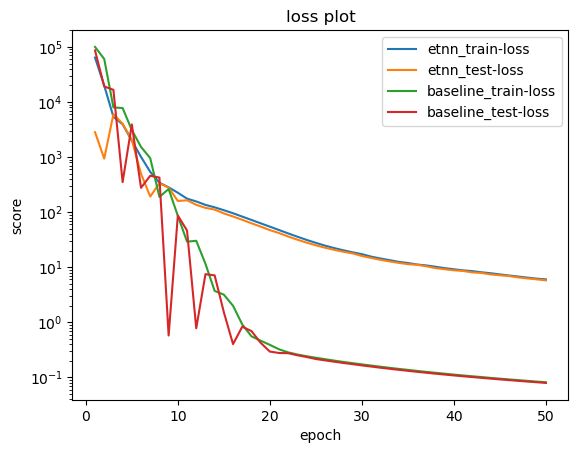

Rank 3 parameter configuration: Unnamed: 0                                      12
number                                          12
value                                     0.924516
datetime_start          2023-12-20 19:59:12.894787
datetime_complete       2023-12-20 20:00:25.849425
duration                    0 days 00:01:12.954638
params_batcher                               False
params_hidden_dim                              112
params_k                                         3
params_learning_rate                      0.008149
state                                     COMPLETE
Name: 12, dtype: object
Model params etnn: 35057


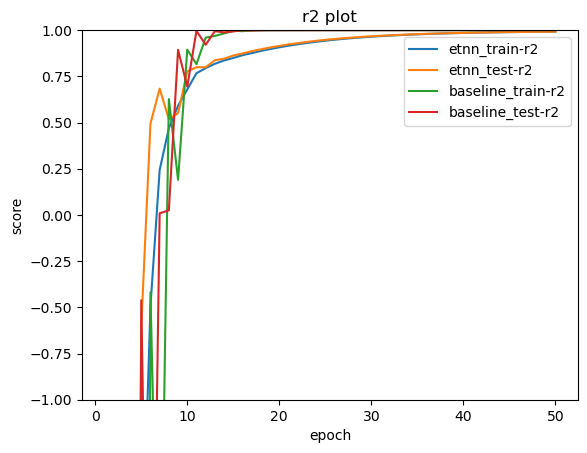

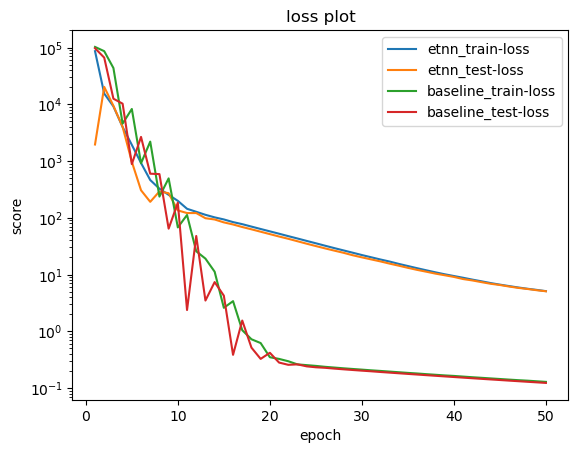

In [8]:
normalized = True
size_elem = 10
node_type = "P"

config_table = pd.read_csv(f"csvs/single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}_normalized-lesser-search.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)